In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
from zipfile import ZipFile
import os

uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
zip_path = keras.utils.get_file(origin=uri, fname="jena_climate_2009_2016.csv.zip")
zip_file = ZipFile(zip_path)
zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"

df = pd.read_csv(csv_path)

In [3]:
titles = [
    "Pressure",
    "Temperature",
    "Temperature in Kelvin",
    "Temperature (dew point)",
    "Relative Humidity",
    "Saturation vapor pressure",
    "Vapor pressure",
    "Vapor pressure deficit",
    "Specific humidity",
    "Water vapor concentration",
    "Airtight",
    "Wind speed",
    "Maximum wind speed",
    "Wind direction in degrees",
]

feature_keys = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPact (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]

date_time_key = "Date Time"


def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=7, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()


# show_raw_visualization(df)

In [28]:
# split_fraction = 0.715
# train_split = int(split_fraction * int(df.shape[0]))

step = 6
look_back = 72
learning_rate = 0.001
batch_size = 256
epochs = 10

sequence_length = int(look_back / step)

# def normalize(data, train_split):
#     data_mean = data[:train_split].mean(axis=0)
#     data_std = data[:train_split].std(axis=0)
#     return (data - data_mean) / data_std

def normalize(data):
    data_mean = data.mean(axis=0)
    data_std = data.std(axis=0)
    return (data - data_mean) / data_std

In [49]:
# Select independent variables
feature_index = [1, 4]
selected_features = [feature_keys[i] for i in feature_index]
features = df[selected_features]
features.index = df[date_time_key]
features = normalize(features.values)
features = pd.DataFrame(features)

# Dependent variables
selected_labels = feature_keys[8]
labels = df[selected_labels]
labels.index = df[date_time_key]
labels = normalize(labels.values)
labels = pd.DataFrame(labels)

In [50]:
# Make a dataset object from the features and labels

ds = keras.preprocessing.timeseries_dataset_from_array(
    features,
    labels,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)


In [51]:
# I don't like how the test/train datasets were previously split, 
# so let's do it differently.

# Old way:
# train_data = features.loc[0 : train_split - 1]
# val_data = features.loc[train_split:]


# New way:
def is_test(x, y):
    return x % 4 == 0

def is_train(x, y):
    return not is_test(x, y)

recover = lambda x,y: y

dataset_val = ds.enumerate() \
                    .filter(is_test) \
                    .map(recover)

dataset_train = ds.enumerate() \
                    .filter(is_train) \
                    .map(recover)

In [52]:
for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (256, 12, 2)
Target shape: (256, 1)


In [53]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 12, 2)]           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                4480      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 4,513
Trainable params: 4,513
Non-trainable params: 0
_________________________________________________________________


In [54]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/10
1232/1232 [==============================] - 24s 19ms/step - loss: 0.1017 - val_loss: 0.0464

Epoch 00001: val_loss improved from inf to 0.04637, saving model to model_checkpoint.h5
Epoch 2/10
1232/1232 [==============================] - 23s 19ms/step - loss: 0.0410 - val_loss: 0.0230

Epoch 00002: val_loss improved from 0.04637 to 0.02300, saving model to model_checkpoint.h5
Epoch 3/10
1232/1232 [==============================] - 23s 19ms/step - loss: 0.0279 - val_loss: 0.0218

Epoch 00003: val_loss improved from 0.02300 to 0.02185, saving model to model_checkpoint.h5
Epoch 4/10
1232/1232 [==============================] - 22s 18ms/step - loss: 0.0232 - val_loss: 0.0160

Epoch 00004: val_loss improved from 0.02185 to 0.01597, saving model to model_checkpoint.h5
Epoch 5/10
1232/1232 [==============================] - 23s 19ms/step - loss: 0.0169 - val_loss: 0.0147

Epoch 00005: val_loss improved from 0.01597 to 0.01473, saving model to model_checkpoint.h5
Epoch 6/10
1232/123

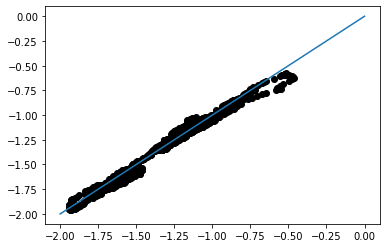

In [61]:
plt.subplots()
for x, y in dataset_val.take(5):
    plt.plot(y,model.predict(x),'ok')
plt.plot((-2,0),(-2,0))